# Power Restoration

- ####  Create environment and all the appropriate dependencies for pypower with the following command :

    `> conda env create -f environment.yml`

    `> source activate pypower`

## I. Introduction to NEXRAD II radar data - Weather Radar (Level II) [(Link)](https://www.ngdc.noaa.gov/metaview/page?xml=NOAA/NESDIS/NCDC/Geoportal/iso/xml/C00345.xml&view=getDataView&header=none)

 - The Next Generation Weather Radar (NEXRAD) is a network of 160 high-resolution Doppler weather radars operated by the US National Oceanic and Atmospheric Administration (NOAA), National Weather Service (NWS), the Federal Aviation Administration (FAA), and the U.S. Air Force (USAF). 
 
 - Doppler radars detect atmospheric precipitation and winds allowing scientists to track and anticipate weather events, such as rain, ice pellets, snow, hail, and tornadoes, as well as some non-weather objects like birds and insects and disseminates data in approximately 5 minute intervals from each site.
 
 
 - NEXRAD stations use the Weather Surveillance Radar - 1988, Doppler (WSR-88D) system. This is a 10 cm wavelength (S-Band) radar that operates at a frequency between 2,700 and 3,000 MHz. 
 
 - The radar system operates in two basic modes: 
 
     - Mode A (faster-scanning Precipitation Mode) : track active weather
     - Mode B (slow-scanning Clear Air Mode) : analyze air movements when there is little or no precipitation activity in the area

- The NEXRAD products are divided into multiple data processing levels. The lower Level II data contain the three meteorological base data quantities at original resolution: 

        - reflectivity
        - mean radial velocity
        - spectrum width
        - differential reflectivity
        - correlation coefficient 
        - differential phase 



## II. The properties of radar data 

- Reflectivity (Z)

- Velocity (V)

- Spectrum Width (SW) [(here)](https://www.weather.gov/media/lmk/soo/SpectrumWidth_Operational_Use.pdf)

- Differential Reflectivity (ZDR)

- Correlation Coefficient (CC)

- Specific Differential Phase (KDP)

##### a. Reflectivity (Z) [(Link)](https://www.weather.gov/media/lmk/soo/Dual_Pol_Overview.pdf)

- A measure of the efficiency of a radar target in intercepting and returning radio energy. It depends upon the size, shape, aspect, and dielectric properties of the target.

- A quantity determined by the drop-size distribution of precipitation, which is proportional to the radar reflectivity if the precipitation particles are spheres small compared with the radar wavelength.

- Hail : 40 - 80 dBZ

- Snow/Ice : < 40 dBZ

##### b. Radial Velocity (V) [(Link)](http://wx.db.erau.edu/faculty/mullerb/Wx365/Doppler_velocity/radial_velocity.html)

- The component of wind velocity parallel to the direction of the radar beam either toward or away from the radar.

- Radial velocities are defined as (+) when they are moving away from the radar (outbound).

- Radial velocities are defined as (-) when they are moving toward the radar (inbound).



##### c. Spectrum Width (SW) [(Link)](https://www.weather.gov/media/lmk/soo/SpectrumWidth_Operational_Use.pdf)

- Depicts a measure of velocity dispersion. 

- In a radar bin, it provides a measure of the variability of the mean radial velocity estimates (movement) due to wind shear, turbulence, and/or the quality of the velocity samples. 

- The proper use of Spectrum Width can help the severe thunderstorm and tornado warning decision process. It is used to estimate turbulence associated with low- level boundaries, thunderstorms, mesocyclones in supercells, and mesovortices in quasi-linear convective systems (QLCSs)

##### d. Differential Reflectivity (ZDR) [(Link)](https://www.weather.gov/media/lmk/soo/Dual_Pol_Overview.pdf)

- Difference between horizontal and vertical reflectivity factors = Drop Shape

- ZDR values for rain typically > 1 to as high as 5 for large drops

- ZDR values for snow typically less than 0.5 (except for wet or melting snow when it’s much higher)

- ZDR for hail generally between -1 and +1 (larger values for melting)

##### e. Correlation Coefficient (CC) [(Link)](https://www.weather.gov/media/lmk/soo/Dual_Pol_Overview.pdf)

- Measure of how similarly the horizontally & vertically polarized pulses are behaving within a pulse vol.

- Great at discriminating non vs. meteorological echoes

- Low CC (< 0.8) : Non-Meteorological (birds, insects, etc.)

- Moderate CC (0.80 to 0.97) : Metr (Non-Uniform) (hail, melting snow, etc.)

- High CC (> 0.97) : Metr (Uniform) (rain, snow, etc.)

##### f. Specific Differential Phase (KDP) [(Link)](https://www.weather.gov/media/lmk/soo/Dual_Pol_Overview.pdf)

- Range derivative of differential phase shift along a radial

- Hail – KDP near 0 (except near 3 for melting)

- Snow – KDP typically between -1 and +0.5

- Rain – KDP between 0 and +5 (larger number indicates larger drops and/or increased drop concentration)

- KDP values for non-meteorological echoes are not shown

[PyArt](https://github.com/ARM-DOE/pyart)


[cartopy](https://github.com/SciTools/cartopy/tree/master/)

In [1]:
import pyart
from matplotlib import pyplot as plt
import cartopy

# accessing S3 is to create a connection to the service
from boto.s3.connection import S3Connection
import datetime
import tempfile
import numpy as np
import xarray
import netCDF4 

# make drawing maps for data analysis and visualisation 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter # handling tick marks in cartopy
import cartopy.crs as ccrs # defines Coordinate Reference Systems and the transformations between them.
import cartopy.io.img_tiles as cimgt # implements image tile identification and fetching from various sources.

# accurate and cross platform timezone calculations
import pytz

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## III. Specify an area to retrieve the data

### 1. Managing Amazon S3 (Simple Storage Service) files in Python with Boto [(Link)](http://boto.cloudhackers.com/en/latest/s3_tut.html)

- Boto, an Amazon Web Services API for python and the entire Amazon Web Services (AWS) family. 

- Allows users to store and retrieve content (e.g., files) from storage entities called “S3 Buckets” in the cloud with ease for a relatively small cost. 
 
- Allows users to automate pulling and parsing some content that was stored in an S3 bucket. 



#### a. Creating a Connection
   - accessing S3 is to create a connection to the service
    
        - `from boto.s3.connection import S3Connection`
    
        - `conn = S3Connection('<aws access key>', '<aws secret key>')`
                
#### b.  Accessing and Listing Files from in an S3 Bucket [(Tutorial)](https://spin.atomicobject.com/2014/09/24/automate-amazon-s3-python/)
   - accesing a bucket which stores key/value pairs in S3
    
        - `bucket = conn.get_bucket('bucket_name')` 
      
   - listing of keys in the bucket   
    
        - `bucket.list()` 

   - getting a list of files using the prefix argument to the bucket.list method
    
        - `bucket_list = list(bucket.list(prefix='prefix_string'))`

### 2. Accessing the Archive Data from Amazon Web Services [(Link)](https://aws.amazon.com/public-datasets/nexrad/)

- The NEXRAD Level II archive data is hosted in the “noaa-nexrad-level2” Amazon S3 bucket in S3’s US East region. The address for the public bucket is: https://noaa-nexrad-level2.s3.amazonaws.com


- Each volume scan file of archival data is available as an object in Amazon S3. The basic data format is:

    `/<Year>/<Month>/<Day>/<NEXRAD Station/>/<filename>`

- The file naming convention is:

    `GGGGYYYYMMDD_TTTTTT`

    Where:

    GGGG = Ground station ID (map of ground stations)

    YYYY = year

    MM = month

    DD = day

    TTTTTT = time when data started to be collected (GMT)


- The 2015 files add “_V06” to the end of the file name. 
    - Example: KABX20150303_001050_V06.gz.

In [2]:
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime_t.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime_t.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    print(keys[index])
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

In [3]:
def grids_to_x(grids):
    long, lat = grids.get_point_longitude_latitude()
    height = grids.point_z['data'][:,0,0]
    time = np.array([ netCDF4.num2date(grids.time['data'][0], grids.time['units'])])
    ds = xarray.Dataset()
    for this_field in list(grids.fields.keys()):
        this_data = grids.fields[this_field]['data']
        my_data = xarray.DataArray(np.ma.expand_dims(this_data,0),
                                   dims = ('time', 'z', 'y', 'x'),
                                   coords = {'time' : (['time'], time),
                                             'z' : (['z'], height),
                                             'lat' :(['y','x'], lat),
                                             'lon' : (['y','x'],long),
                                              'y' : (['y'],lat[:,0]),
                                              'x' : (['x'],long[0,:])})

        for this_meta in list(grids.fields[this_field].keys()):
            if this_meta is not 'data':
                my_data.attrs.update({this_meta: grids.fields[this_field][this_meta]})

        ds[this_field] = my_data
        ds.lon.attrs = [('long_name', 'longitude of grid cell center'),
                 ('units', 'degrees_east')]
        ds.lat.attrs = [('long_name', 'latitude of grid cell center'),
                 ('units', 'degrees_north')]
        ds.z.attrs['long_name'] = "height above sea sea level"
        ds.z.attrs['units'] = "m"

        ds.z.encoding['_FillValue'] = None
        ds.lat.encoding['_FillValue'] = None
        ds.lon.encoding['_FillValue'] = None
    return ds

[Speckle radar](https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/ers/instruments/sar/applications/radar-courses/content-3/-/asset_publisher/mQ9R7ZVkKg5P/content/radar-course-3-image-interpretation-tone)

In [4]:
def make_radar_grid(date_desired, site, tz = None, gridspec = None):
    if tz is None:
        tz = 'US/Eastern'
    
    if gridspec is None:
        gridspec = {}
        gridspec['size'] = (1,801,801)
        gridspec['domain'] = ((1000.,1001.),(-200000.,200000.),(-200000.,200000.))
    
    radar = get_radar_from_aws(site, date_desired)
    flds = radar.fields.keys()
    sweep = 0
    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = netCDF4.num2date(radar.time['data'][index_at_start], 
                                      radar.time['units'])
    eastern = pytz.timezone(tz)
    local_time = eastern.fromutc(time_at_start_of_radar)
    fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    speckles_radar = pyart.correct.despeckle.despeckle_field(radar, 'reflectivity')
    grids = pyart.map.grid_from_radars((radar,), gridspec['size'],
                       gridspec['domain'],
                       fields=flds,
                       refl_field='reflectivity', 
                       gatefilters=(speckles_radar, )) 
    
    xar = grids_to_x(grids)
    return xar
    

### 3. Accessing NEXRAD dataset from a radar station


 `dt = datetime.datetime(YYYY,MM,DD,0,0)`
    
 `this_ds = make_radar_grid(dt, 'KGGG')`
    
  Where:

  GGG = Ground station ID [(map of ground stations)](https://team.carto.com/u/stuartlynn/viz/881236cc-35ff-11e5-a112-0e5e07bb5d8a/public_map)

   YYYY = year

  MM = month

  DD = day
     
 

<img src="../../radar_map.png">

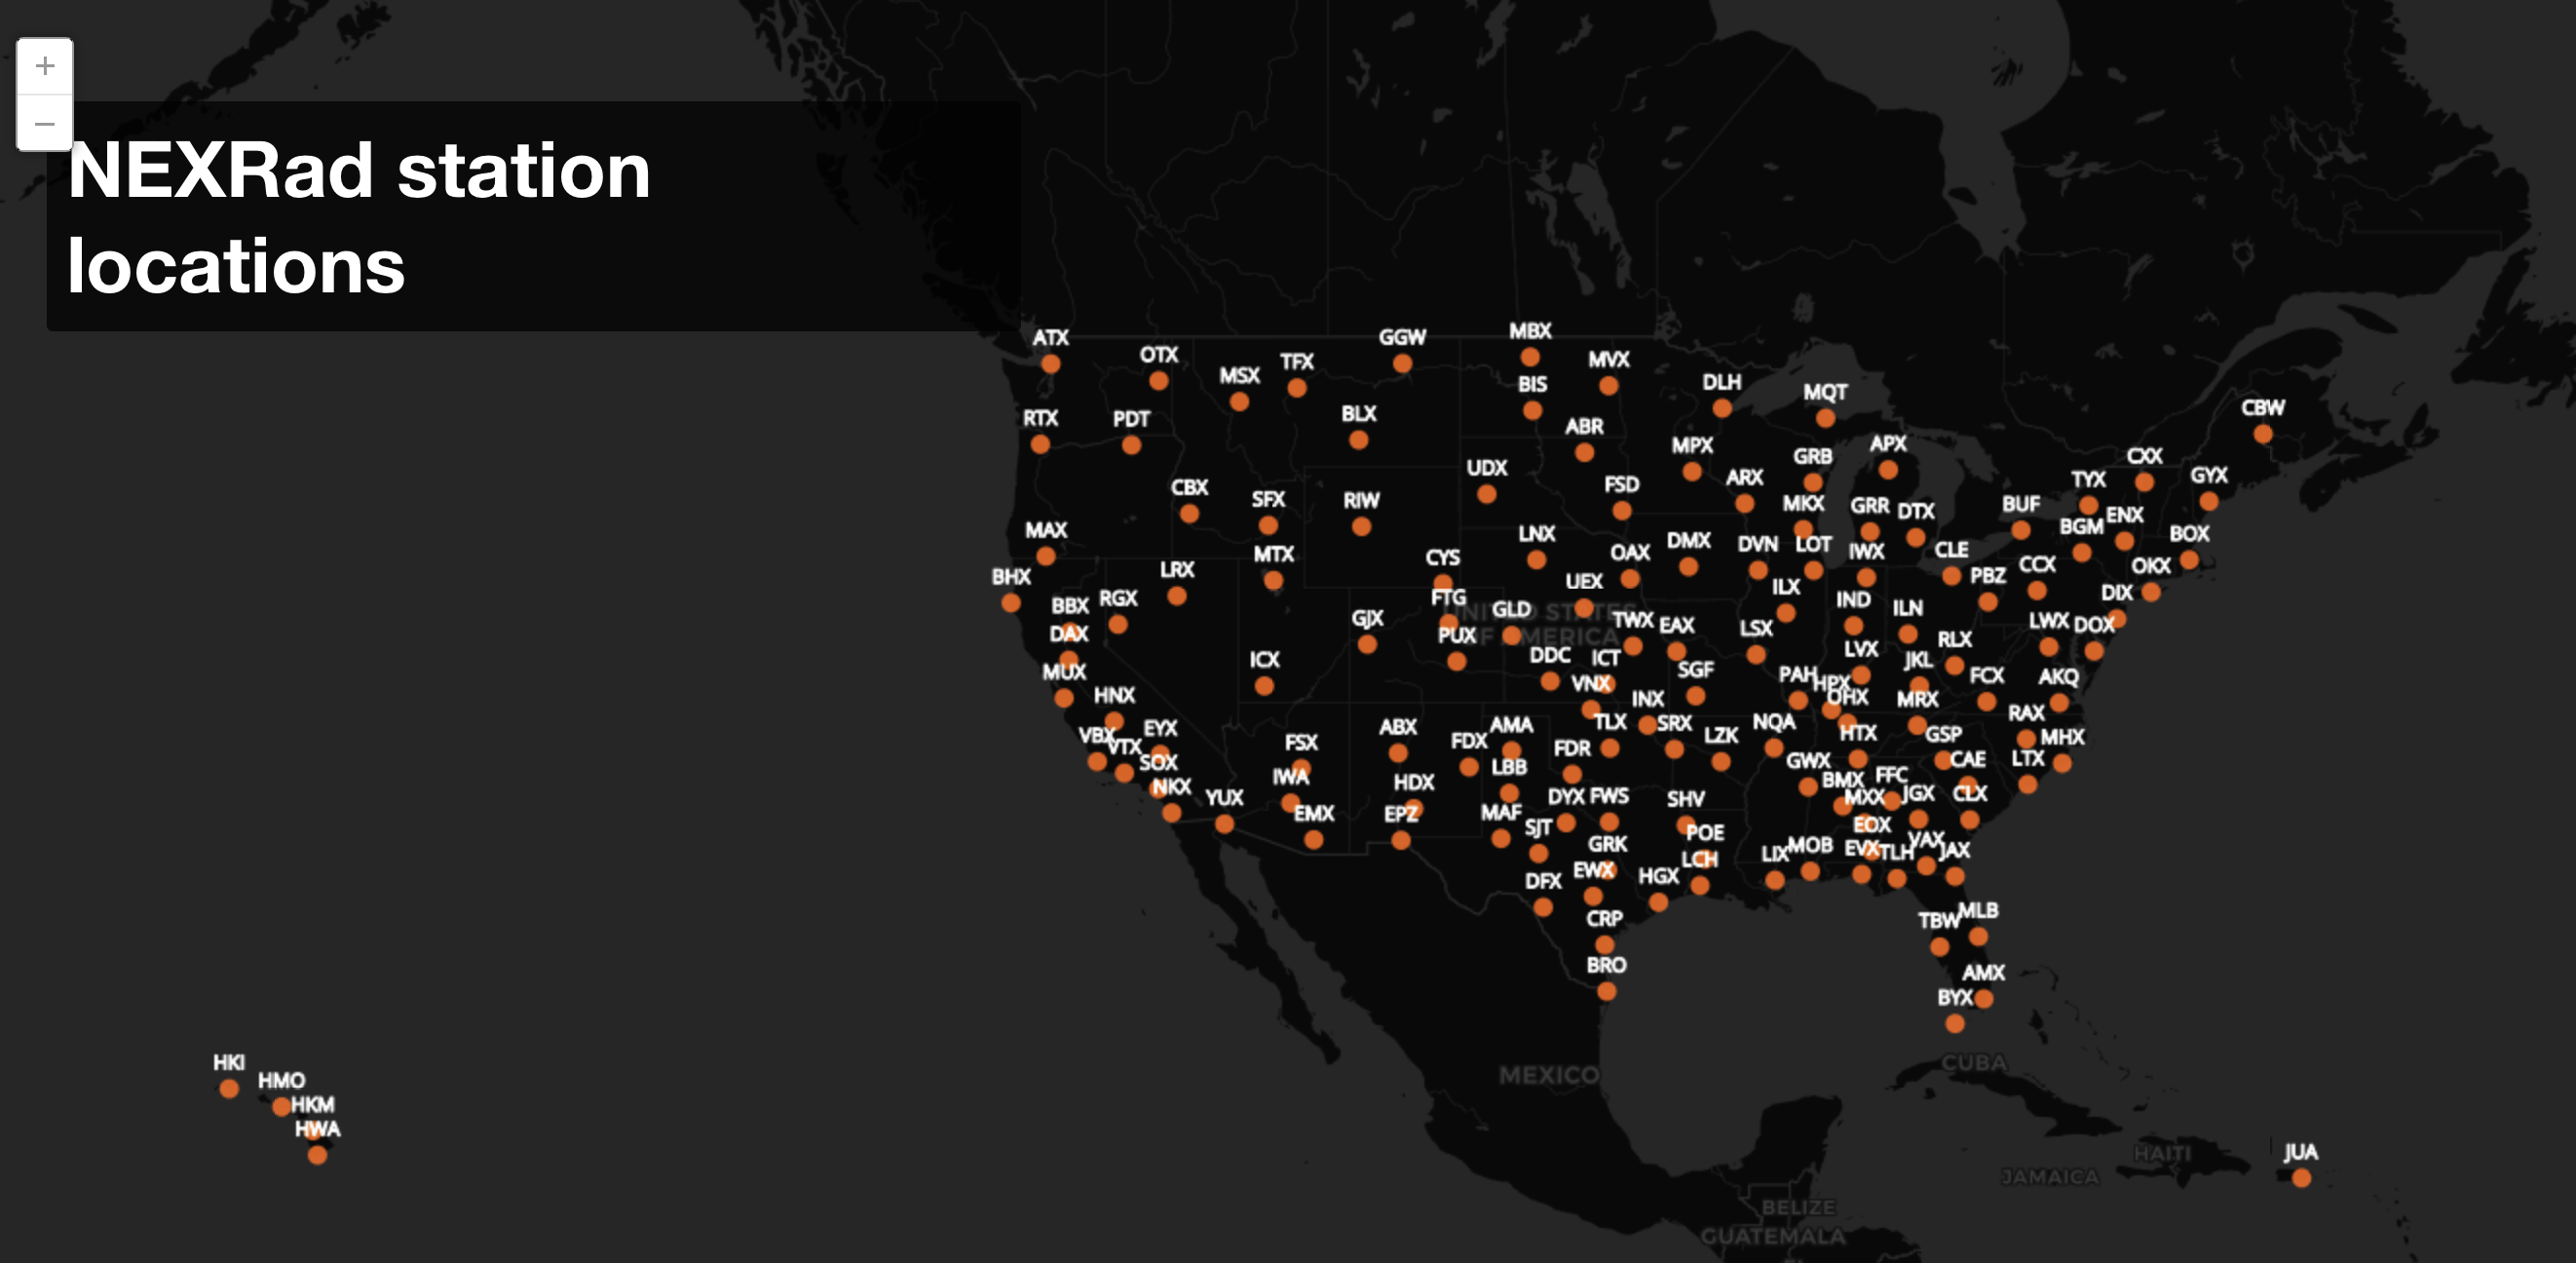

In [2]:
from IPython.display import Image
Image(filename='../../radar_map.png') 

### a. Explore NEXRAD data at Fort Dix, NJ/Philadelphia, PA in 10/29/2012

In [5]:
dt = datetime.datetime(2012,10,29,0,0)
this_ds = make_radar_grid(dt, 'KDIX')

<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_000319_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [6]:
this_ds

<xarray.Dataset>
Dimensions:                    (time: 1, x: 801, y: 801, z: 1)
Coordinates:
  * time                       (time) datetime64[ns] 2012-10-29T00:03:19.196000
  * z                          (z) float64 1e+03
    lat                        (y, x) float64 38.13 38.13 38.13 38.13 38.13 ...
    lon                        (y, x) float64 -76.7 -76.69 -76.69 -76.68 ...
  * y                          (y) float64 38.13 38.13 38.13 38.14 38.14 ...
  * x                          (x) float64 -76.7 -76.69 -76.69 -76.68 -76.67 ...
Data variables:
    reflectivity               (time, z, y, x) float32 15.162318 15.562643 ...
    cross_correlation_ratio    (time, z, y, x) float32 1.0055563 0.9972958 ...
    differential_reflectivity  (time, z, y, x) float32 0.69841987 0.5406287 ...
    spectrum_width             (time, z, y, x) float32 nan nan nan nan nan ...
    differential_phase         (time, z, y, x) float32 62.808247 62.08878 ...
    velocity                   (time, z, y, x) float

#### Reflectivity (Z)

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


NameError: name 'fancy_date_string' is not defined

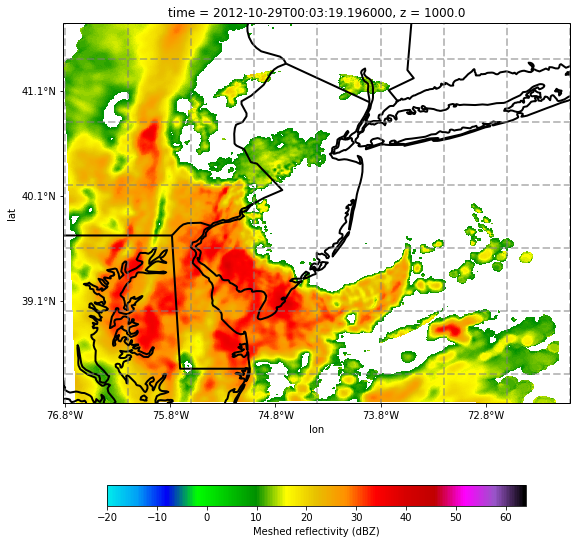

In [7]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

z_var = this_ds.reflectivity[0].sel(z=1000, method='nearest')
pc = z_var.where(z_var > 10).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-20,
                                                    vmax=64, cmap=pyart.graph.cm.NWSRef,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed reflectivity (dBZ)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

#### Velocity (V)

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

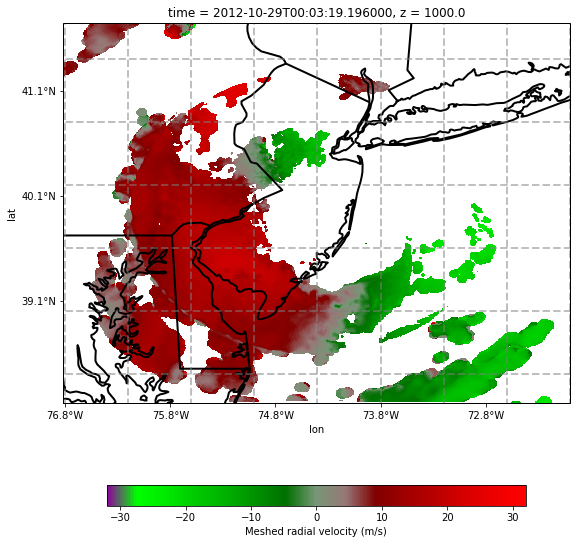

In [8]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

v_var = this_ds.velocity[0].sel(z=1000, method='nearest')
pc = v_var.where(z_var > 10).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-32,
                                                    vmax=32, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed radial velocity (m/s)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

#### Spectrum Width (SW) 

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

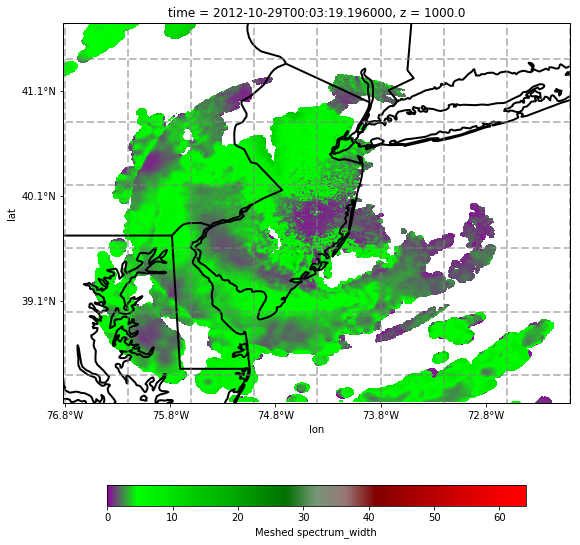

In [12]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

v_var = this_ds.spectrum_width[0].sel(z=1000, method='nearest')
pc = v_var.where(z_var > 0).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=0,
                                                    vmax=64, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed spectrum_width')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')



#### Differential Reflectivity (ZDR)


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

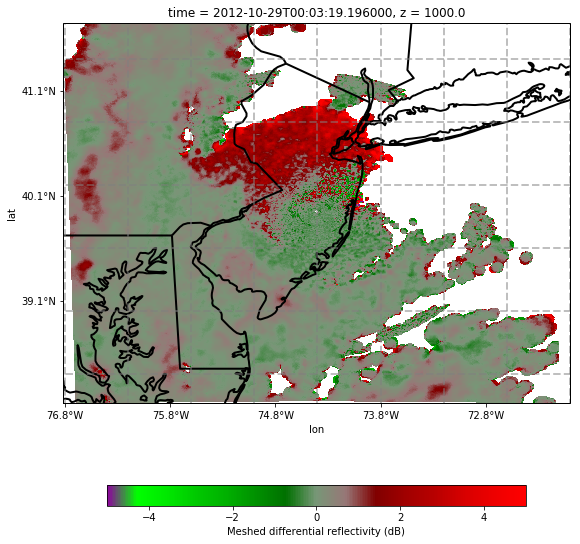

In [13]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

v_var = this_ds.differential_reflectivity[0].sel(z=1000, method='nearest')
pc = v_var.where(z_var > -0.2).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-5,
                                                    vmax=5, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed differential reflectivity (dB)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

#### Correlation Coefficient (CC)

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

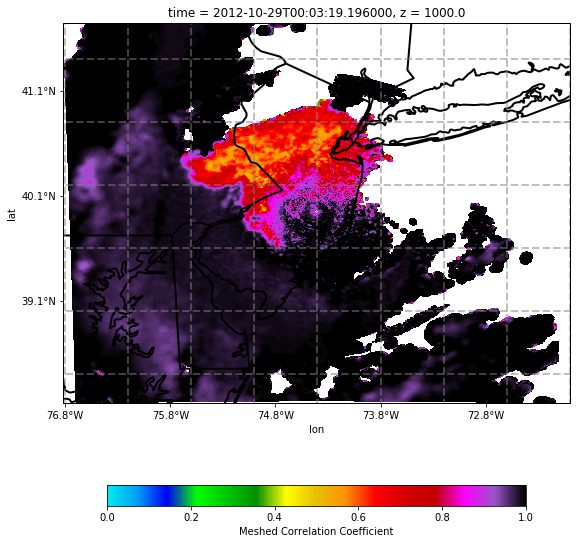

In [14]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

z_var = this_ds.cross_correlation_ratio[0].sel(z=1000, method='nearest')
pc = z_var.where(z_var > 0).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=0,
                                                    vmax=1, cmap=pyart.graph.cm.NWSRef,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed Correlation Coefficient')


my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')


political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)


extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

#### Specific Differential Phase (KDP)

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

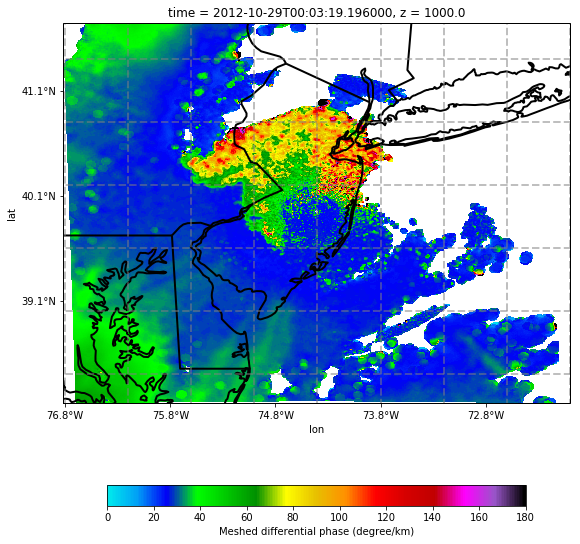

In [15]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

z_var = this_ds.differential_phase[0].sel(z=1000, method='nearest')
pc = z_var.where(z_var > 0).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=0,
                                                    vmax=180, cmap=pyart.graph.cm.NWSRef,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed differential phase (degree/km)')


my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')


political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)


extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')


#### ROI

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

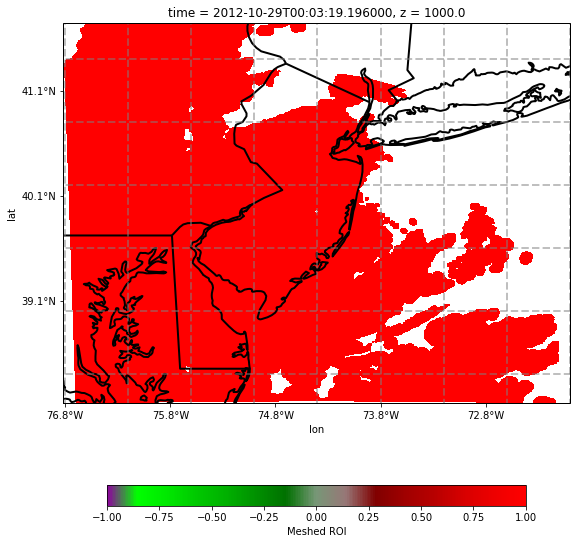

In [16]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

v_var = this_ds.ROI[0].sel(z=1000, method='nearest')
pc = v_var.where(z_var > 0.2).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-1,
                                                    vmax=1, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed ROI')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

### b. Explore NEXRAD data at Chicago, IL  in 02/09/2018

In [17]:
dt = datetime.datetime(2018,2,9,0,0)
this_ds = make_radar_grid(dt, 'KLOT')

<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_000753_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


#### Reflectivity (Z)

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

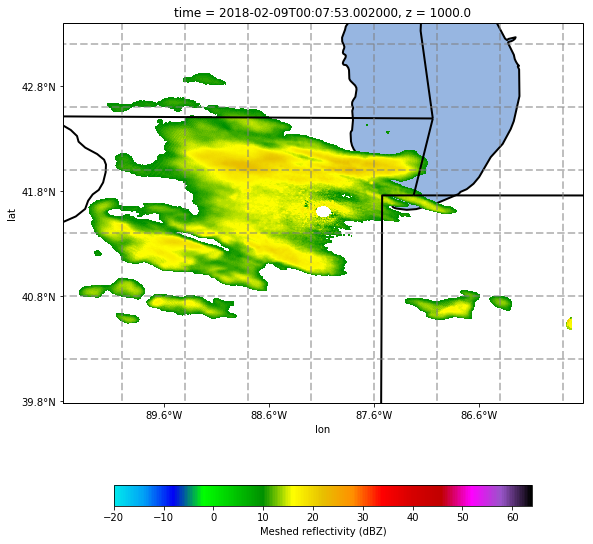

In [18]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

z_var = this_ds.reflectivity[0].sel(z=1000, method='nearest')
pc = z_var.where(z_var > 10).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-20,
                                                    vmax=64, cmap=pyart.graph.cm.NWSRef,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed reflectivity (dBZ)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

#### Velocity (V)

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

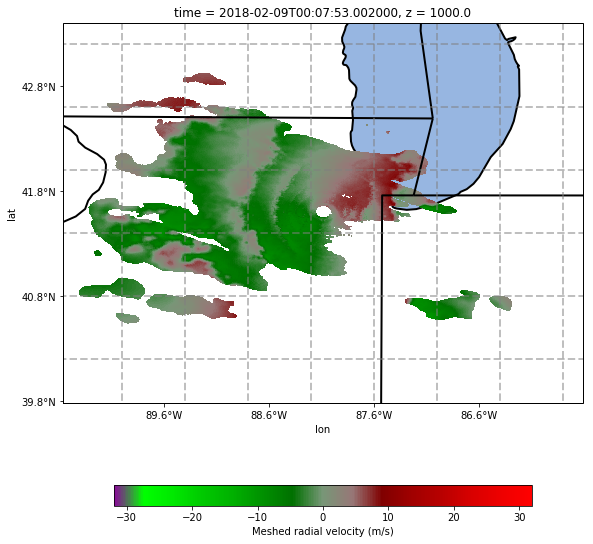

In [19]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

v_var = this_ds.velocity[0].sel(z=1000, method='nearest')
pc = v_var.where(z_var > 10).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-32,
                                                    vmax=32, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed radial velocity (m/s)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

#### Spectrum Width (SW) 

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

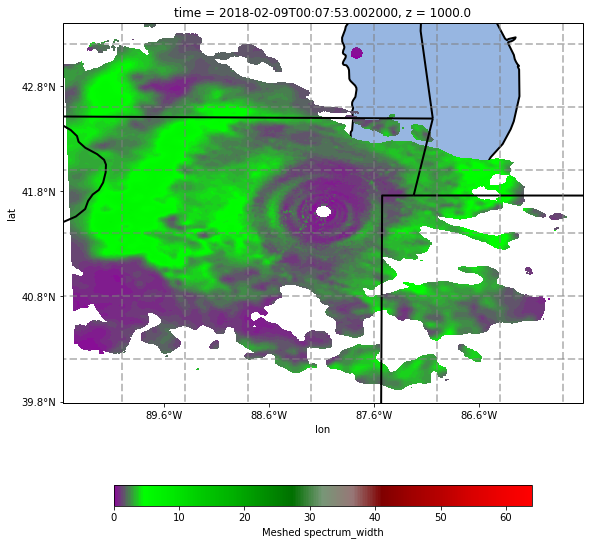

In [20]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

v_var = this_ds.spectrum_width[0].sel(z=1000, method='nearest')
pc = v_var.where(z_var > 0).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=0,
                                                    vmax=64, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed spectrum_width')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')




#### Differential Reflectivity (ZDR)

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

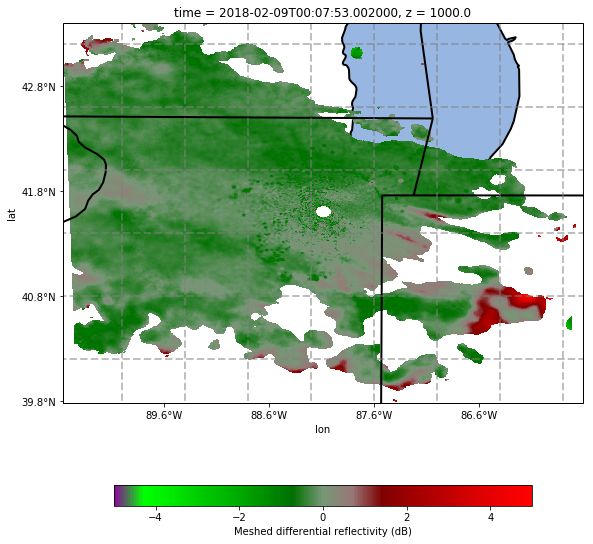

In [21]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

v_var = this_ds.differential_reflectivity[0].sel(z=1000, method='nearest')
pc = v_var.where(z_var > -0.2).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-5,
                                                    vmax=5, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed differential reflectivity (dB)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

#### Correlation Coefficient (CC)

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

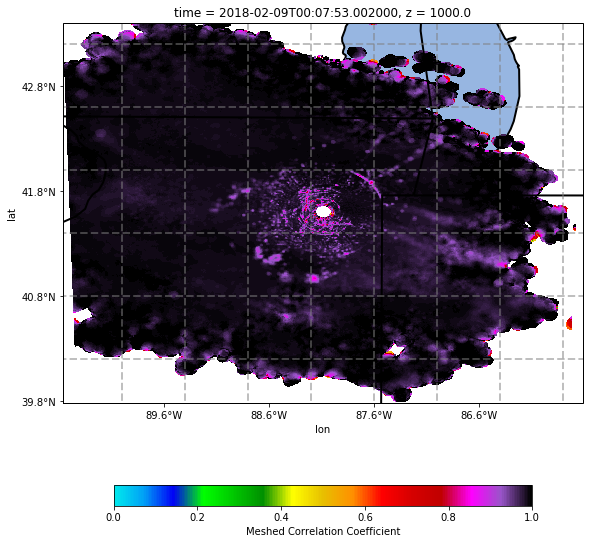

In [22]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

z_var = this_ds.cross_correlation_ratio[0].sel(z=1000, method='nearest')
pc = z_var.where(z_var > 0).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=0,
                                                    vmax=1, cmap=pyart.graph.cm.NWSRef,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed Correlation Coefficient')


my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')


political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)


extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

#### Specific Differential Phase (KDP)

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

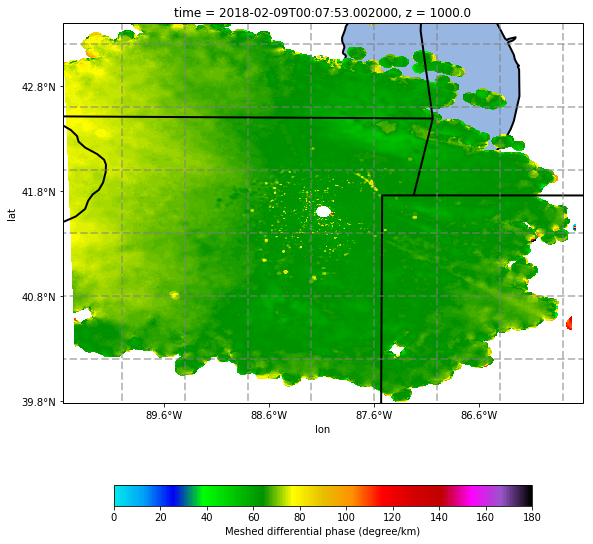

In [23]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

z_var = this_ds.differential_phase[0].sel(z=1000, method='nearest')
pc = z_var.where(z_var > 0).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=0,
                                                    vmax=180, cmap=pyart.graph.cm.NWSRef,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed differential phase (degree/km)')


my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')


political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)


extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')



#### ROI

/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


NameError: name 'fancy_date_string' is not defined

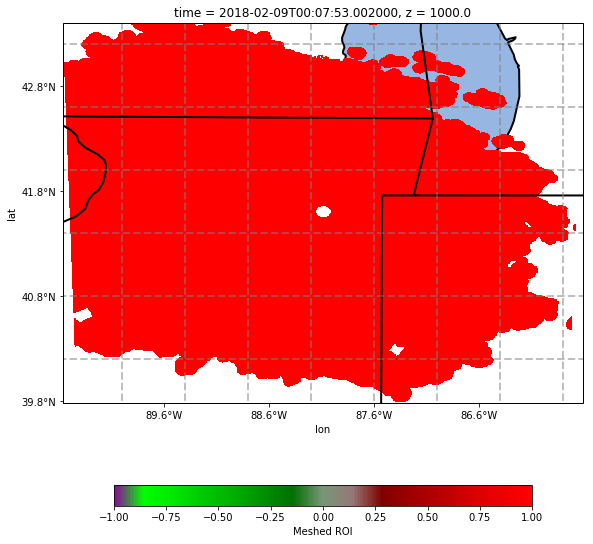

In [24]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

v_var = this_ds.ROI[0].sel(z=1000, method='nearest')
pc = v_var.where(z_var > 0.2).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-1,
                                                    vmax=1, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed ROI')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

## III. Specify the duration to retrieve the data

### 1. Retrieve NEXRAD data at Fort Dix, NJ/Philadelphia, PA in 10/29/2012 at interval of 10 minutes

In [25]:
dt = datetime.datetime(2012,10,29,0,0)
ds = make_radar_grid(dt, 'KDIX')
for i in range(15):
    dt += datetime.timedelta(minutes=10)
    print(dt)
    thisds = make_radar_grid(dt, 'KDIX')
    ds = xarray.concat((ds, thisds), dim='time')

<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_000319_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 00:10:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_000905_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 00:20:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_002038_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 00:30:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_003209_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 00:40:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_003754_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 00:50:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_004927_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 01:00:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_010058_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 01:10:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_011230_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 01:20:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_011816_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 01:30:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_012947_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 01:40:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_014120_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 01:50:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_015252_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 02:00:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_020047_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 02:10:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_021220_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 02:20:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_021806_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 02:30:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_022937_V06.gz>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [29]:
ds

<xarray.Dataset>
Dimensions:                    (time: 16, x: 801, y: 801, z: 1)
Coordinates:
  * z                          (z) float64 1e+03
    lat                        (y, x) float64 38.13 38.13 38.13 38.13 38.13 ...
    lon                        (y, x) float64 -76.7 -76.69 -76.69 -76.68 ...
  * y                          (y) float64 38.13 38.13 38.13 38.14 38.14 ...
  * x                          (x) float64 -76.7 -76.69 -76.69 -76.68 -76.67 ...
  * time                       (time) datetime64[ns] 2012-10-29T00:03:19.196000 ...
Data variables:
    reflectivity               (time, z, y, x) float32 15.162318 15.562643 ...
    cross_correlation_ratio    (time, z, y, x) float32 1.0055563 0.9972958 ...
    differential_reflectivity  (time, z, y, x) float32 0.69841987 0.5406287 ...
    spectrum_width             (time, z, y, x) float32 nan nan nan nan nan ...
    differential_phase         (time, z, y, x) float32 62.808247 62.08878 ...
    velocity                   (time, z, y, x) 

In [30]:
ssds = ds.sel(x=slice(-75.8, -75.5), y=slice(40.0, 40.3), z=1000.0)

In [ ]:
this_ds = ds.sel(time=datetime.datetime(2012,10,29,0,10), method='nearest')
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

v_var = this_ds.velocity.sel(z=1000, method='nearest')
pc = v_var.where(z_var > 10).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-32,
                                                    vmax=32, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed radial velocity (m/s)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

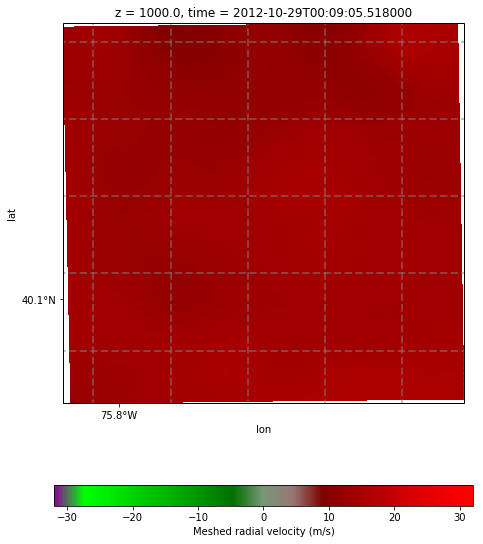

In [34]:
fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

tsme = ssds.sel(time=datetime.datetime(2012,10,29,0,10), method='nearest')
pc = tsme.velocity.plot.pcolormesh(transform=ccrs.PlateCarree(),
                                                x='lon', y='lat', vmin=-32,
                                                    vmax=32, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)
cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed radial velocity (m/s)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [tsme.lon.min(), tsme.lon.max(), tsme.lat.min(), tsme.lat.max()]
my_ax.set_extent(extent)

### 2. Retrieve NEXRAD data at Chicago, IL in 02/09/2018 at interval of 10 minutes 

In [38]:
dt = datetime.datetime(2018,2,9,0,0)
ds = make_radar_grid(dt, 'KLOT')
for i in range(15):
    dt += datetime.timedelta(minutes=10)
    print(dt)
    thisds = make_radar_grid(dt, 'KLOT')
    ds = xarray.concat((ds, thisds), dim='time')

<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_000753_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 00:10:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_000753_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 00:20:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_001739_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 00:30:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_002726_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 00:40:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_003712_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 00:50:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_004659_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 01:00:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_005645_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 01:10:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_010632_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 01:20:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_011618_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 01:30:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_012605_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 01:40:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_013551_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 01:50:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_014538_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 02:00:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_015525_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 02:10:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_020511_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 02:20:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_022445_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2018-02-09 02:30:00
<Key: noaa-nexrad-level2,2018/02/09/KLOT/KLOT20180209_023432_V06>


/Users/ducvu/anaconda2/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [39]:
ds

<xarray.Dataset>
Dimensions:                    (time: 16, x: 801, y: 801, z: 1)
Coordinates:
  * z                          (z) float64 1e+03
    lat                        (y, x) float64 39.78 39.78 39.78 39.78 39.78 ...
    lon                        (y, x) float64 -90.42 -90.42 -90.41 -90.41 ...
  * y                          (y) float64 39.78 39.79 39.79 39.8 39.8 39.8 ...
  * x                          (x) float64 -90.42 -90.42 -90.41 -90.41 -90.4 ...
  * time                       (time) datetime64[ns] 2018-02-09T00:07:53.002000 ...
Data variables:
    reflectivity               (time, z, y, x) float32 nan nan nan nan nan ...
    cross_correlation_ratio    (time, z, y, x) float32 nan nan nan nan nan ...
    differential_reflectivity  (time, z, y, x) float32 nan nan nan nan nan ...
    spectrum_width             (time, z, y, x) float32 nan nan nan nan nan ...
    differential_phase         (time, z, y, x) float32 nan nan nan nan nan ...
    velocity                   (time, z, y,

In [40]:
ssds = ds.sel(x=slice(-75.8, -75.5), y=slice(40.0, 40.3), z=1000.0)

In [ ]:
this_ds = ds.sel(time=datetime.datetime(2012,10,29,0,10), method='nearest')
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

v_var = this_ds.velocity.sel(z=1000, method='nearest')
pc = v_var.where(z_var > 10).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-32,
                                                    vmax=32, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed radial velocity (m/s)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

## V. Explore the properties of the radar data 

### 1. Velocity (V)

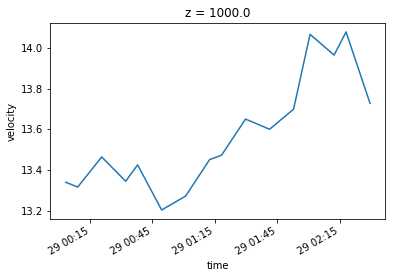

In [13]:
ssds.velocity.mean(dim=('x','y'), skipna=True).plot()

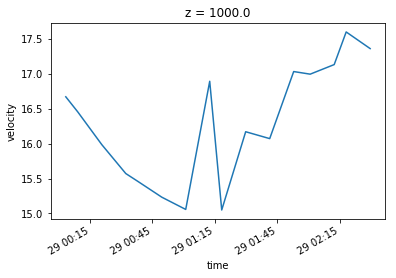

In [14]:
ssds.velocity.max(dim=('x','y'), skipna=True).plot()

### 2. Reflectivity (Z)

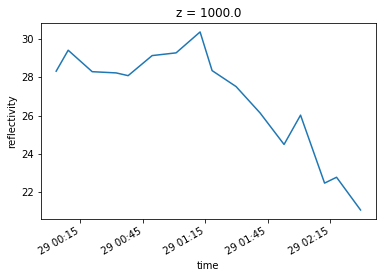

In [15]:
ssds.reflectivity.max(dim=('x','y'), skipna=True).plot()

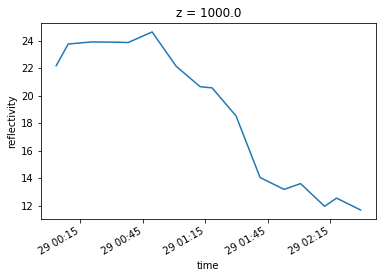

In [16]:
ssds.reflectivity.mean(dim=('x','y'), skipna=True).plot()

### 3. Differential reflectivity (ZDR)

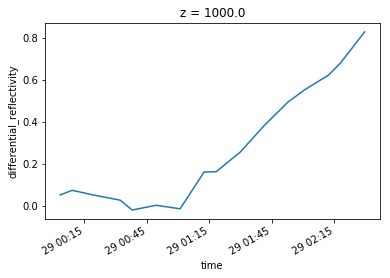

In [17]:
ssds.differential_reflectivity.mean(dim=('x','y'), skipna=True).plot()

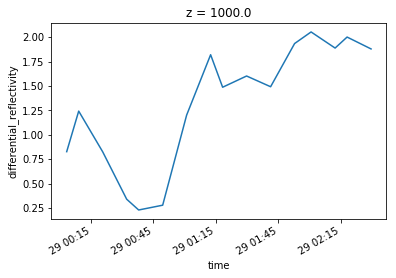

In [21]:
ssds.differential_reflectivity.max(dim=('x','y'), skipna=True).plot()

### 4. Specific Differential phase (KDP)

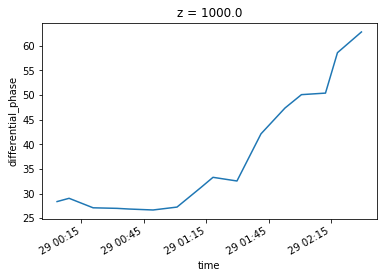

In [20]:
ssds.differential_phase.mean(dim=('x','y'), skipna=True).plot()

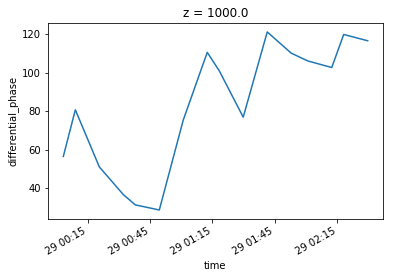

In [22]:
ssds.differential_phase.max(dim=('x','y'), skipna=True).plot()

### 5. Spectrum width (SW)

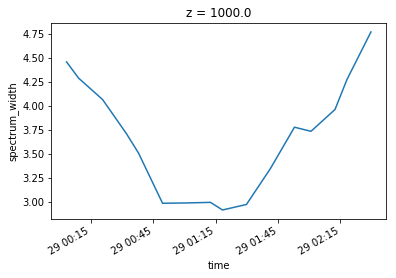

In [26]:
ssds.spectrum_width.mean(dim=('x','y'), skipna=True).plot()

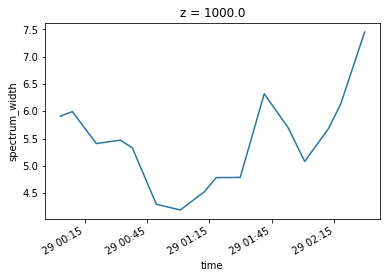

In [27]:
ssds.spectrum_width.max(dim=('x','y'), skipna=True).plot()

### 6. Correlation coefficient (CC)

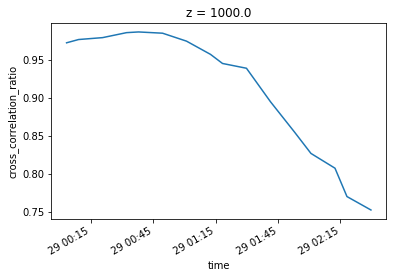

In [32]:
ssds.cross_correlation_ratio.mean(dim=('x','y'), skipna=True).plot()

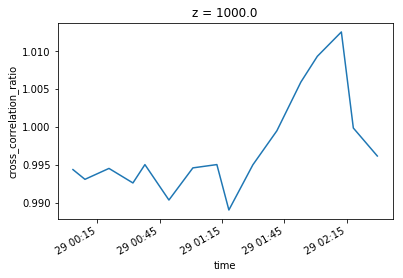

In [33]:
ssds.cross_correlation_ratio.max(dim=('x','y'), skipna=True).plot()